# Using the LSST Stack Multiband Deblender 
<br>Owner(s): **Fred Moolekamp** ([@fred3m](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@fred3m))
<br>Last Verified to Run: **2020-02-07**
<br>Verified Stack Release: **w_2020_04**

This tutorial is designed to illustrate how to execute the multiband deblender (*scarlet*) in the LSST stack. This includes a brief introduction to LSST stack objects including:

 - Geometry classes from `lsst.geom`, such as points and boxes.
 - Higher-level astronomical primitives from `lsst.afw`, such as the `Image`, `Exposure`, and `Psf` classes.
 - Our core algorithmic `Task` classes, including those for source detection, deblending, and measurement.
 
We'll be working with coadded images made from Subaru Hyper Suprime-Cam (HSC) data in the COSMOS field.  We've taken a recent LSST reprocessing of the HSC-SSP UltraDeep COSMOS field (see [this page](https://confluence.lsstcorp.org/display/DM/S18+HSC+PDR1+reprocessing) for information on that reprocessing, and [this page](https://hsc-release.mtk.nao.ac.jp/doc/) for the data), and added simulated stars from a scaled [SDSS catalog](http://www.sdss.org/dr14/data_access/value-added-catalogs/?vac_id=photometry-of-crowded-fields-in-sdss-for-galactic-globular-and-open-clusters).  The result is a very deep image (deeper than the 10-year LSST Deep-Wide-Fast survey, though not as deep as LSST Deep Drilling fields will be) with both a large number of galaxies and region full of stars.

This tutorial is based on Jim Bosch's globular cluster tutorial, however in it's present state *scarlet* is unable to process the crowded field (most likely) due to poor initial conditions for the sources in the field. So instead we use a region of the image outside of the cluster.

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Configure and run the LSST multiband deblender on a test list of objects;
2. Understand its task context in the DRP pipeline.

### Logistics
This notebook is intended to be runnable on a **large** instance of the LSP on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

In [1]:
# What version of the Stack are we using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-kadrlica-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


## Imports

We'll start with some standard imports of both LSST and third-party packages.

In [2]:
import numpy as np
from lsst.daf.persistence import Butler
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
from lsst.afw.image import Exposure, Image, PARENT, MultibandExposure, MultibandImage
from lsst.afw.detection import MultibandFootprint

In [3]:
from lsst.afw.image import MultibandExposure

## Reading Data

We'll be retrieving data using the `Butler` tool, which manages where various datasets are stored on the filesystem (and can in principle manage datasets that aren't even stored as files, though all of these are).

We start by creating a `Butler` instance, pointing it at a *Data Repository* (which here is just a root directory).

In [4]:
butler = Butler("/project/jbosch/tutorials/lsst2018/data")

Datasets managed by a butler are identified by a dictionary *Data ID* (specifying things like the visit number or sky patch) and a string *DatasetType* (such as a particular image or catalog).  Different DatasetTypes have different keys, while different instances of the same Dataset Type have different values.  All of the datasets we use in this tutorial will correspond to the same patch of sky, so they'll have at least the keys in the dictionary in the next cell (they will also have `filter`, but with different values):

In [5]:
dataId = {"tract": 9813, "patch": "4,4"}

We can now use those to load a set of *grizy* coadds, which we'll put directly in a dictionary.  The result of each `Butler.get` call is in this case an `lsst.afw.image.Exposure` object, an image that actually contains three "planes" (the main image, a bit mask, and a variance image) as well as many other objects that describe the image, such as its PSF and WCS.  Note that we (confusingly) use `Exposures` to hold coadd images as well as true single-exposure images, but combine them into a `MultibandExposure`, which contains an exposure in each band.

The DatasetType here is `deepCoadd_calexp` (a coadd on which we've already done some additional processing, such as subtracting the background and setting some mask values), and the extra `filter` argument gets appended to the Data ID.

In [6]:
filters = "grizy"
coadds = [butler.get("deepCoadd_calexp", dataId, filter="HSC-{}".format(f.upper())) for f in filters]
coadds = MultibandExposure.fromExposures(filters, coadds)

## Making and displaying color composite images

We'll start by just looking at the images, as 3-color composites.  We'll use astropy to build those as a nice way to demonstrate how to get NumPy arrays from the `MultibandImage` objects (the images in `coadds`).  (LSST also has code to make 3-color composites using the same algorithm, and in fact the Astropy implementation is based on ours, but now that it's in Astropy we'll probably retire ours.)

We'll just use matplotlib to display the images themselves.  We'll use Firefly for other image display tasks later, but while Firefly itself supports color-composites, work on our preferred composition algorithm is still in progress, and we haven't quite finished connecting that functionality to the Python client we'll demonstrate here.

In [7]:
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
%matplotlib inline

We'll use the following function a few times to display color images.  It's worth reading through the implementation carefully to see what's going on.

In [8]:
def showRGB(image, bgr="gri", ax=None, fp=None, figsize=(8,8), stretch=1, Q=10):
    """Display an RGB color composite image with matplotlib.
    
    Parameters
    ----------
    image : `MultibandImage`
        `MultibandImage` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e. keys of the exps dict) indicating what band
        to use for each channel. If `image` only has three filters then this parameter is ignored
        and the filters in the image are used.
    ax : `matplotlib.axes.Axes`
        Axis in a `matplotlib.Figure` to display the image.
        If `axis` is `None` then a new figure is created.
    fp: `lsst.afw.detection.Footprint`
        Footprint that contains the peak catalog for peaks in the image.
        If `fp` is `None` then no peak positions are plotted.
    figsize: tuple
        Size of the `matplotlib.Figure` created.
        If `ax` is not `None` then this parameter is ignored.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    """
    # If the image only has 3 bands, reverse the order of the bands to produce the RGB image
    if len(image) == 3:
        bgr = image.filters
    # Extract the primary image component of each Exposure with the .image property, and use .array to get a NumPy array view.
    rgb = make_lupton_rgb(image_r=image[bgr[2]].array,  # numpy array for the r channel
                          image_g=image[bgr[1]].array,  # numpy array for the g channel
                          image_b=image[bgr[0]].array,  # numpy array for the b channel
                          stretch=stretch, Q=Q)  # parameters used to stretch and scale the pixel values
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
    
    # Exposure.getBBox() returns a Box2I, a box with integer pixel coordinates that correspond to the centers of pixels.
    # Matplotlib's `extent` argument expects to receive the coordinates of the edges of pixels, which is what
    # this Box2D (a box with floating-point coordinates) represents.
    integerPixelBBox = image[bgr[0]].getBBox()
    bbox = Box2D(integerPixelBBox)
    ax.imshow(rgb, interpolation='nearest', origin='lower', extent=(bbox.getMinX(), bbox.getMaxX(), bbox.getMinY(), bbox.getMaxY()))
    if fp is not None:
        for peak in fp.getPeaks():
            ax.plot(peak.getIx(), peak.getIy(), "bx", mew=2)

Notice that we can slice `MultibandImage` objects (as well a `MultibandExposure` objects) along the filter dimension using the filter names as indices. Like `Exposure` objects, `MultibandExposure` objects have `image`, `mask`, and `variance` properties that contain the image, mask plane, and variance of the `Exposure` respectively. For now we will only worry about the `image` property, although internal deblending and measurement algorithms make use of all three objects (when available).

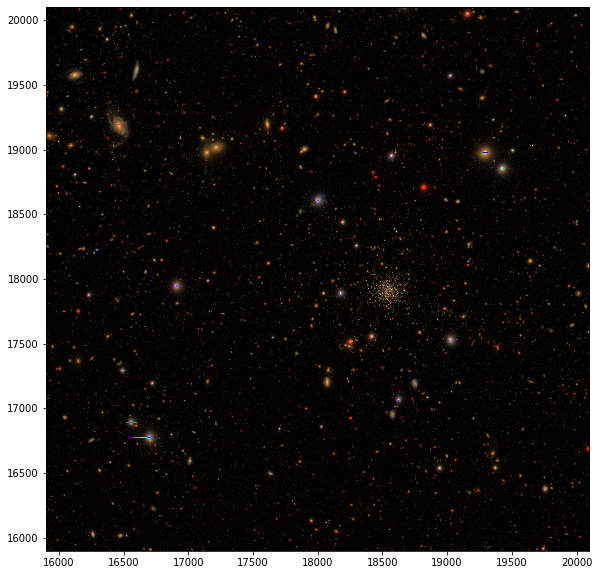

In [9]:
showRGB(coadds[:"z"].image, figsize=(10, 10))

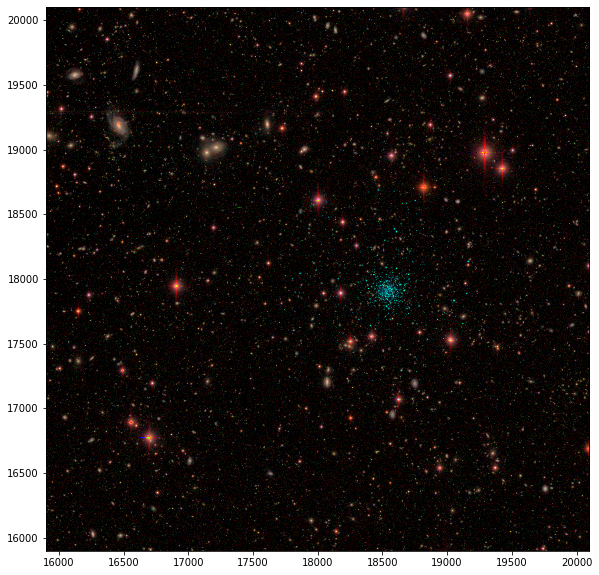

In [10]:
showRGB(coadds["i":].image, figsize=(10, 10))

Those images are a full "patch", which is our usual unit of processing for coadds - it's about the same size as a single LSST sensor (exactly the same in pixels, smaller in terms of area because these use HSC's smaller pixel scale).  That's a bit unweildy (just because waiting for processing to happen isn't fun in a tutorial setting), so we'll reload our dict with sub-images centered on the region of interest.

Note that we can load the sub-images directly with the `butler`, by appending `_sub` to the DatasetType and passing a `bbox` argument. If you want to see the region of the image with the cluster, use `clusterBBox` below, however as mentioned above, that region is too memory intensive for the current version of *scarlet*. Instead use `sampleBBox` to select a sub-region of the image (note that we add a small frame around each blend to include more background regions, which are important for the detection algorithm).

In [11]:
frame = 50
clusterBBox = Box2I(Point2I(18325, 17725), Extent2I(400, 350))

#sampleBBox = Box2I(Point2I(18699-frame, 17138-frame), Extent2I(93+2*frame, 104+2*frame))
#sampleBBox = Box2I(Point2I(16424-frame, 17806-frame), Extent2I(55+2*frame, 62+2*frame))
#sampleBBox = Box2I(Point2I(17838-frame, 18945-frame), Extent2I(111+2*frame, 103+2*frame))
sampleBBox = Box2I(Point2I(19141-frame, 18228-frame), Extent2I(63+2*frame, 87+2*frame))

subset = coadds[:, sampleBBox]
# Due to a bug in the code the PSF isn't copied properly.
# The code below copies the PSF into the `MultibandExposure`,
# but will be unecessary in the future
for f in subset.filters:
    subset[f].setPsf(coadds[f].getPsf())

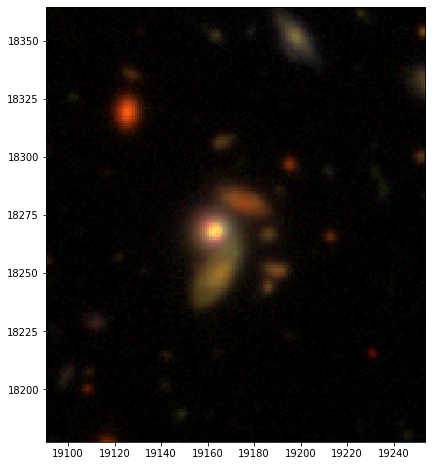

In [12]:
showRGB(subset.image)

## Basic Processing

Now we'll try the regular LSST processing tasks, with a simpler configuration than we usually use to process coadds, just to avoid being distracted by complexity.  This includes

 - Detection (`SourceDetectionTask`): given an `Exposure`, find above-threshold regions and peaks within them (`Footprints`), and create a *parent* source for each `Footprint`.
 - Deblending (`ScarletDeblendTask`): given a `MultibandExposure` and a catalog of parent sources, create a *child* source for each peak in every `Footprint` that contains more than one peak.  Each child source is given a `HeavyFootprint`, which contains both the pixel region that source covers and the fractional pixel values associated with that source. A `SourceDeblendTask` is also available using the single band SDSS-HSC deblender that takes a single band `Exposure`).
 - Measurment (`SingleFrameMeasurementTask`): given an `Exposure` and a catalog of sources, run a set of "measurement plugins" on each source, using deblended pixel values if it is a child. Notice that measurement is still performed on single band catalogs, since none of the measurement algorithms work for multiband data.

We'll start by importing these, along with the `SourceCatalog` class we'll use to hold the outputs.

In [13]:
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.extensions.scarlet.deblend import ScarletDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.afw.table import SourceCatalog

We'll now construct all of these `Tasks` before actually running any of them.  That's because `SourceDeblendTask` and `SingleFrameMeasurementTask` are constructed with a `Schema` object that records what fields they'll produce, and they modify that schema when they're constructed by adding columns to it.  When we run the tasks later, they'll need to be given a catalog that includes all of those columns, **but we can't add columns to a catalog that already exists**.

To recap, the sequence looks like this:

 1. Make a (mostly) empty schema.
 2. Construct all of the `Task`s (in the order you plan to run them), which adds columns to the schema.
 3. Make a `SourceCatalog` object from the *complete* schema.
 4. Pass the same `SourceCatalog` object to each `Task` when you run it.

In [14]:
schema = SourceCatalog.Table.makeMinimalSchema()

detectionTask = SourceDetectionTask(schema=schema)

config = ScarletDeblendTask.ConfigClass()
config.maxIter = 100
deblendTask = ScarletDeblendTask(schema=schema, config=config)

# We'll customize the configuration of measurement to just run a few plugins.
# The default list of plugins is much longer (and hence slower).
measureConfig = SingleFrameMeasurementTask.ConfigClass()
measureConfig.plugins.names = ["base_SdssCentroid", "base_PsfFlux", "base_SkyCoord"]
# "Slots" are aliases that provide easy access to certain plugins.
# Because we're not running the plugin these slots refer to by default,
# we need to disable them in the configuration.
measureConfig.slots.apFlux = None
#measureConfig.slots.instFlux = None
measureConfig.slots.shape = None
measureConfig.slots.modelFlux = None
measureConfig.slots.calibFlux = None
measureConfig.slots.gaussianFlux = None
measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)

The first step we'll run is detection, which actually returns a new `SourceCatalog` object rather than working on an existing one.

Instead, it takes a `Table` object, which is sort of like a factory for records.  We won't use it directly after this, and it isn't actually necessary to make a new `Table` every time you run `MultibandDetectionTask` (but you can only create one after you're done adding columns to the schema).

`Task`s that return anything do so via a `lsst.pipe.base.Struct` object, which is just a simple collection of named attributes.  The only return values we're  interested is `sources`.  That's our new `SourceCatalog`.

In [15]:
table = SourceCatalog.Table.make(schema)
detectionResult = detectionTask.run(table, subset["r"])
catalog = detectionResult.sources

In [16]:
catalog.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['F'](name="runtime", doc="runtime in ms"), Key<F>(offset=32, nElements=1)),
    (Field['I'](name="iterations", doc="iterations to converge"), Key<I>(offset=36, nElements=1)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>(offset=40, nElements=1)),
    (Field['Flag'](name="deblend_deblendedAsPsf", doc="Deblender thought this source looked like a PSF"), Key['Flag'](offset=48, bit=0)),
    (Field['Flag'](name="deblend_tooManyPeaks", doc="Source had too many peaks; only the brightest were included"), Key['Flag'](offset=48, bit=1)),
    (Field[

Let's take a quick look at what's in that catalog.  First off, we can look at its schema:

Note that this includes a lot of columns that were actually added by the deblend or measurement steps; those will all still be blank (`0` for integers or flags, `NaN` for floating-point columns).

In fact, the only columns filled by `SourceDetectionTask` are the IDs.  But it also attaches `Footprint` objects, which don't appear in the schema.  You can retrieve the `Footprint` by calling `getFootprint()` on a row:

In [17]:
footprint = catalog[0].getFootprint()

`Footprints` have two components:
 - a `SpanSet`, which represents an irregular region on an image via a list of (y, x0, x1) `Spans`;
 - a `PeakCatalog`, a slightly different kind of catalog whose rows represent peaks within that `Footprint`.

In [18]:
print(footprint.getSpans())

18180: 19244..19246
18181: 19243..19247
18182: 19242..19248
18183: 19241..19249
18184: 19242..19248
18185: 19243..19247
18186: 19244..19246



In [19]:
print(footprint.getPeaks())

 id   f_x     f_y    i_x   i_y   peakValue 
      pix     pix    pix   pix       ct    
--- ------- ------- ----- ----- -----------
  1 19245.0 18183.0 19245 18183 0.032013237


If we actually look at the footprints in the catalog we see that some have only a single peak, while others have multiple peaks that need to be deblended.

To display only the pixels contained in the footprint (and not other pixels in the bounding box) we create a `MultibandFootprint`, which is a `HeavyFootprint` that contains a `SpanSet`, `PeakCatalog`, and `flux` values for all of the pixels in the `SpanSet`. In this case the `flux` is the total measured flux in the image, since no deblending has taken place yet.

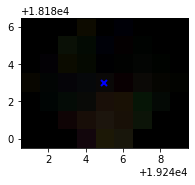

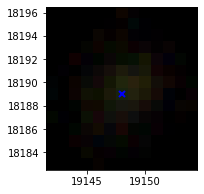

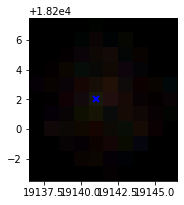

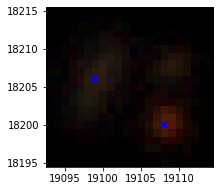

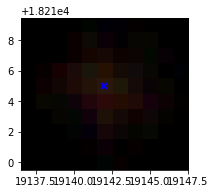

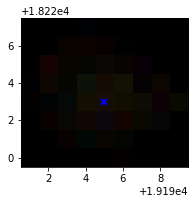

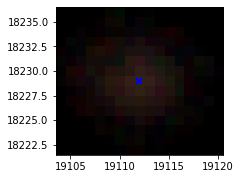

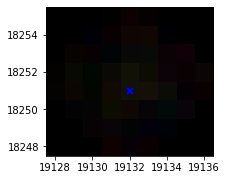

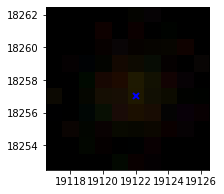

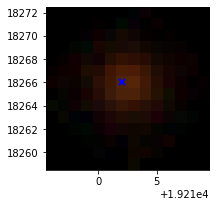

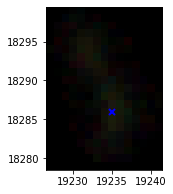

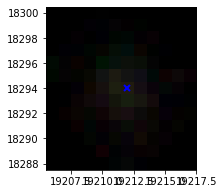

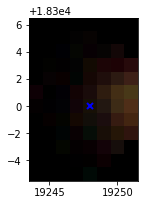

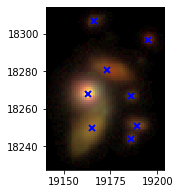

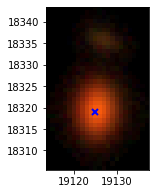

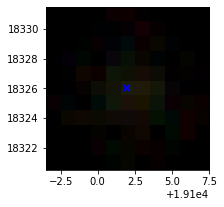

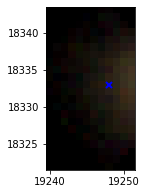

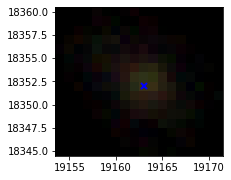

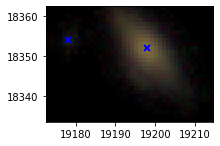

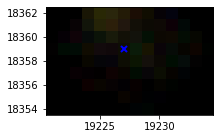

In [20]:
for src in catalog:
    fp = src.getFootprint()
    img = coadds[:,fp.getBBox()].image
    mfp = MultibandFootprint.fromImages(coadds.filters, image=img, footprint=fp)
    showRGB(mfp.getImage().image, fp=fp, figsize=(3,3))

It's worth noting that while the peaks *can* have both an integer-valued position and a floating-point position, they're the same right now; `SourceDetectionTask` currently just finds the pixels that are local minima and doesn't try to find their sub-pixel locations.  That's left to the centroider, which is part of the measurement stage.

Before we can get to that point, we need to run the deblender:

In [21]:
_, templateCatalog = deblendTask.run(coadds, catalog)

`ScarletDeblendTask` always returns two catalogs, a `templateCatalog` that contains the model outputs from *scarlet* and a place holder for a`fluxCatalog`, which will use the *scarlet* models as weights to redistribute the flux from the input image (in other words they will contain flux-conserved models). For now only the template catalogs are produced.

The deblender itself sets the `parent` column for each source, which is `0` for objects with no parent, and all of the columns that begin with `deblend_` and also adds new rows to the catalog for each child. It does *not* remove the parent rows it created those child rows from, and this is intentional, because we want to measure both "interpretations" of the blend family: one in which there is only one object (the parent version) and one in which there are several (the children). Before doing any science with the outputs of an LSST catalog, it's important to remove one of those interpretations (typically the parent one).  That can be done by looking at the `deblend_nChild` and `parent` fields:

 - `parent` is the ID of the source from which this was deblended, or `0` if the source is itself a parent.
 - `deblend_nChild` is the number of child sources this source has (so it's `0` for sources that are themselves children or were never blended).
 
Together, these define two particularly useful filters:

 - `deblend_nChild == 0`: never-blended object or de-blended child
 - `deblend_nChild == 0 and parent == 0`: never-blended object
 
The first is what you'll usually want to use; the second is what to use if you're willing to throw away some objects (possibly many) because you don't trust the deblender.

The last processing step for our purposes is running measurement, which must be done on each catalog, in each band (if we want measurements for all of them):

In [22]:
measureTask.run(templateCatalog["r"], coadds['r'])
measureTask.run(templateCatalog["i"], coadds['i'])

Due to an unfortunate bug in the deblender task, the resulting catalogs are not contiguous and we need to copy them into new objects to use them appropriately. This step can be avoided in the near future.

In [23]:
import lsst.afw.table as afwTable

for f in filters:
    _catalog = afwTable.SourceCatalog(templateCatalog[f].table.clone())
    _catalog.extend(templateCatalog[f], deep=True)
    templateCatalog[f] = _catalog

Since we care about deblending (for the sake of this tutorial) lets look at the results from the 13th blend displayed above. We use the `HeavyFootprint`s from the catalog sources that have the same parent (parent 13 from above) to build a model for the entre scene, and to compare the results of the flux conserved and *scarlet* models. In the process we look at both the *scarlet* and flux conserved models.

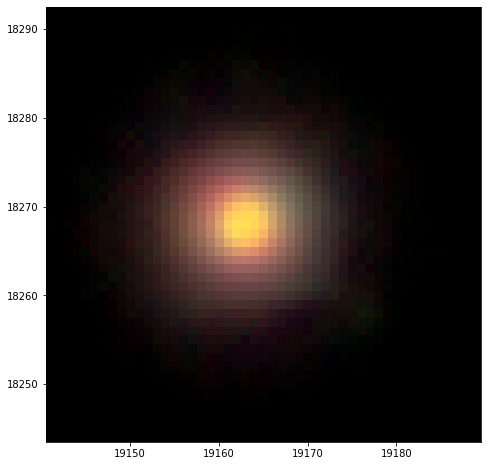

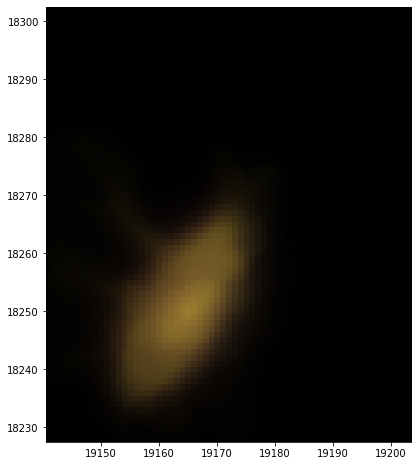

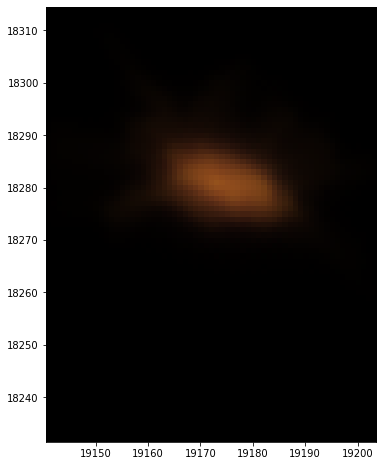

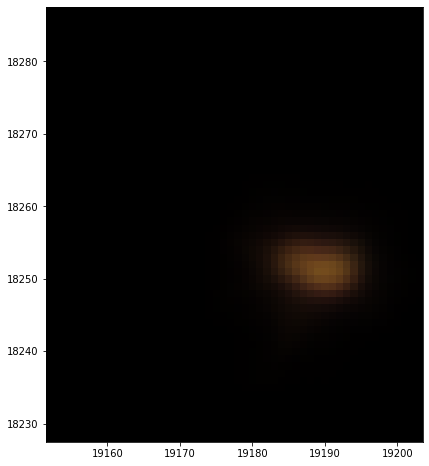

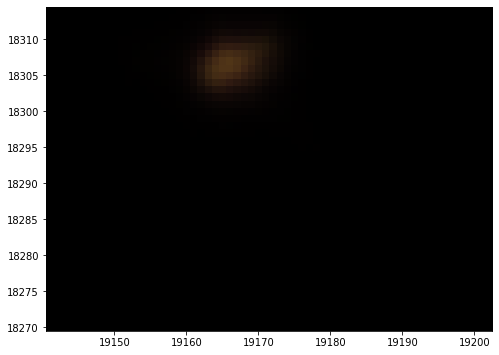

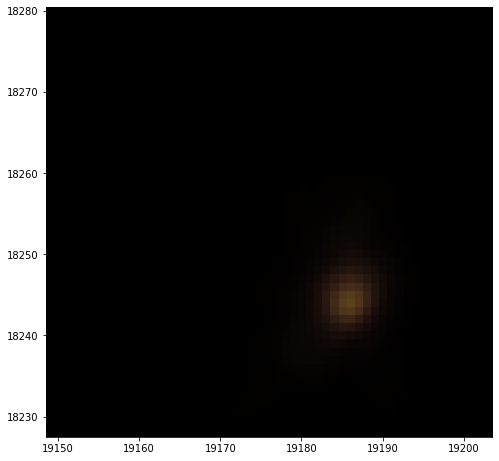

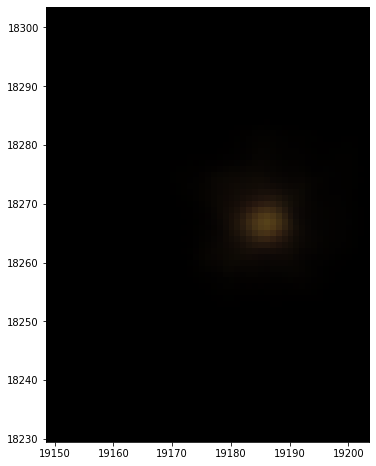

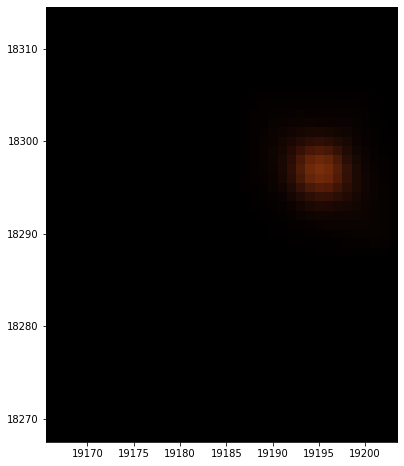

In [24]:
from lsst.afw.detection import MultibandFootprint
from lsst.afw.image import MultibandImage

# Use the 13th parent in the blend
# Note: this is not the parent ID, but the 13th source in the catalog
parentIdx = 13

# Create empty multiband images to model the entire scene
templateModel = MultibandImage.fromImages(coadds.filters,
                                          [Image(templateCatalog["r"][parentIdx].getFootprint().getBBox(), dtype=np.float32)
                                           for b in range(len(filters))])

# Only use the subset catalogs with the same parent
parentId = templateCatalog["r"][parentIdx].get("id")
templateChildren = {b: templateCatalog[b][templateCatalog[b].get("parent")==parentId] for b in filters}

for n in range(len(templateChildren["r"])):
    # Add the source model to the model of the entire scene
    fp = MultibandFootprint(coadds.filters, [templateChildren[b][n].getFootprint() for b in filters])
    templateModel[:, fp.getBBox()].array += fp.getImage(fill=0).image.array

    # Show the model
    showRGB(fp.getImage().image)
    plt.show()

templateResidual = MultibandImage(coadds.filters,
                                  coadds[:, templateModel.getBBox()].image.array - templateModel.array)

Finally we look at the full models and the residuals. As expected, there are no residuals for the flux conserved model since all of the flux in the image (that is within the footprint) is added to one of the sources. In this particular case that works fine, but in instances where one or more sources were not detected this can cause one source to have its flux contaminated with its neighbor.

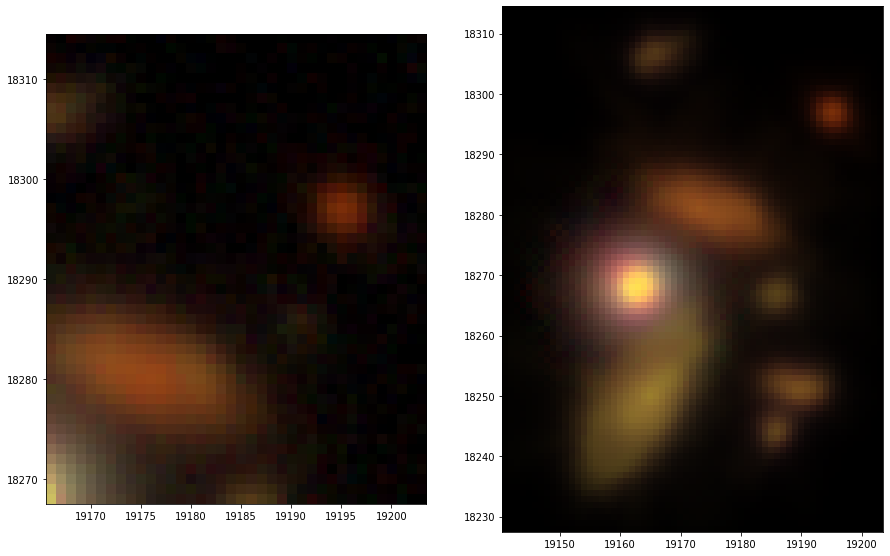

In [25]:
fig = plt.figure(figsize=(15,10))
ax = [fig.add_subplot(1,2,n+1) for n in range(2)]
showRGB(coadds[:,fp.getBBox()].image, ax=ax[0])
showRGB(templateModel, ax=ax[1])

# Exercises

- Use some of the other`sampleBBox` regions and run through the code again, from source detection through measurment and blending displays. Don't foget to change the parent index to view only the children of the correct blend.
- Look at the configuration options on https://github.com/lsst/meas_extensions_scarlet/blob/master/python/lsst/meas/extensions/scarlet/deblend.py and modify some of them to see the changes in results. For example, set `config.symmetric=False` to turn off symmetry to see the effect of deblending without symmetry. 